In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm

%matplotlib inline


# Predicting Craigslist Car Prices

The goal of this project is to predict car prices on Craigslist using KNN regression and OLS to compare their performance

#### Function Definitions

In [2]:
def bayes_opt_resutls(model, hyper_min, hyper_max, n_iter, cv, xtrain, ytrain, xtest, ytest):
    m_name = ''
    if str(model) == str(Lasso()):
        m_name = 'Lasso'
        params = {
            'alpha':Real(hyper_min,hyper_max, prior='uniform'),
            'fit_intercept':Categorical([True, False]),
        }
        opt = BayesSearchCV(
            model, 
            params,
            cv=cv,
            random_state=15,
            n_iter=n_iter,
            selection='random'
        )
                       
    elif str(model) == str(Ridge()):
        m_name = 'Ridge'
        params = {
            'alpha':Real(hyper_min,hyper_max, prior='uniform'),
            'fit_intercept':Categorical([True, False]),
            'solver':Categorical(['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
        }
        opt = BayesSearchCV(
            model, 
            params,
            cv=cv,
            random_state=15,
            n_iter=n_iter,
            selection='random'
        )
        
    elif str(model) == str(ElasticNet()):
        m_name = 'ElasticNet' 
        params = {
            'alpha':Real(hyper_min, hyper_max, prior='uniform'),
            'l1_ratio':Real(hyper_min, hyper_max, prior='uniform'),
            'fit_intercept':Categorical([True, False]),
        }
        opt = BayesSearchCV(
            model, 
            params,
            cv=cv,
            random_state=15,
            n_iter=n_iter,
            selection='random'
        )

    #training the data with the tuned hyperparameters from bayesian search
    opt.fit(xtrain, ytrain)
    
    print('***** {} Tuned Hyperparameters *****\n'.format(m_name))
    print('Bayesian Search CV parameters: {:.3g}'.format(opt.best_params_))
    
    Y_train_pred = opt.predict(xtrain)
    Y_test_pred = opt.predict(xtest)
        
    print('\n***** {} Training Set Statistics *****'.format(m_name))
    print('\nR-squared of the training set is: {:.3f}'.format(opt.score(xtrain, ytrain)))
    print('Root mean squared error of the training set is: {:.2f}'.format(rmse(ytrain, Y_train_pred)))
    print('\n***** {} Test Set Statistics *****'.format(m_name))
    print('\nR-squared of the test set is: {:.3f}'.format(opt.score(xtest, ytest)))
    print('Root mean squared error of the prediction is: {:.2f}'.format(rmse(ytest, y_test_pred)))

In [3]:
#dataset comes from Kaggle user @AustinReese
craig = pd.read_csv('craigslist_vehicles_full.csv')
craig.head()

,url,city,price,year,manufacturer,make,condition,cylinders,fuel,odometer,...,paint_color,image_url,lat,long,county_fips,county_name,state_fips,state_code,state_name,weather
0,https://marshall.craigslist.org/cto/d/2010-dod...,marshall,11900,2010.0,dodge,challenger se,good,6 cylinders,gas,43600.0,...,red,https://images.craigslist.org/00i0i_2ggH1eKDNK...,43.4775,-96.7041,46083.0,Lincoln,46.0,SD,South Dakota,38.0
1,https://marshall.craigslist.org/cto/d/fleetwoo...,marshall,1515,1999.0,NaN,fleetwood,NaN,NaN,gas,NaN,...,NaN,https://images.craigslist.org/00M0M_irjh7SjEcU...,44.7612,-96.6907,46039.0,Deuel,46.0,SD,South Dakota,38.0
2,https://marshall.craigslist.org/cto/d/2008-for...,marshall,17550,2008.0,ford,f-150,NaN,NaN,gas,NaN,...,NaN,https://images.craigslist.org/00s0s_eL2XFhEUcx...,44.1415,-103.2052,46093.0,Meade,46.0,SD,South Dakota,38.0
3,https://marshall.craigslist.org/cto/d/ford-tau...,marshall,2800,2004.0,ford,taurus,good,6 cylinders,gas,168591.0,...,grey,https://images.craigslist.org/00L0L_5HUR1nQjt8...,43.2845,-95.5930,19143.0,Osceola,19.0,IA,Iowa,47.0
4,https://marshall.craigslist.org/cto/d/2001-gra...,marshall,400,2001.0,NaN,2001 Grand Prix,NaN,NaN,gas,217000.0,...,NaN,https://images.craigslist.org/00n0n_bJJ1XnonSG...,43.0261,-94.4064,19109.0,Kossuth,19.0,IA,Iowa,47.0


In [4]:
#removing the url columns
craig.drop(['url', 'image_url'], axis=1, inplace=True)

In [5]:
#setting plot asthetics and sizes
sns.set(style='white', rc={'figure.figsize':(12,6)})

### Data Cleaning, EDA, and Feature Engineering

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


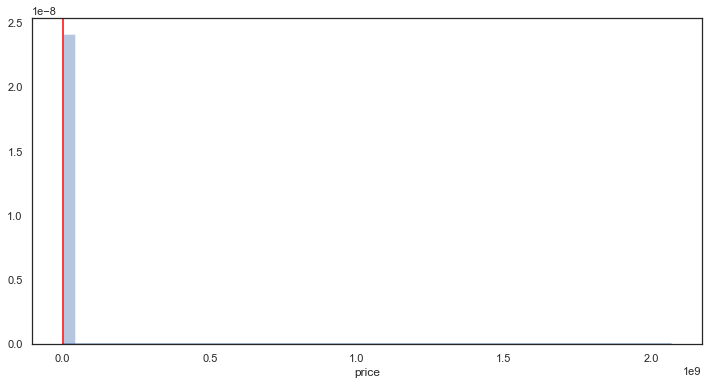

In [6]:
#checking the distribution of the target variable
sns.distplot(craig.price)
plt.axvline(craig.price.mean(), color='red')
plt.show()

In [7]:
#summary statistics of the continuous variables in the dataset
print(craig.describe())
print(craig.columns)

              price          year      odometer           lat          long  \
count  1.723065e+06  1.716750e+06  1.159011e+06  1.723065e+06  1.723065e+06   
mean   1.075540e+05  2.004841e+03  1.136387e+05  3.878195e+01 -9.371198e+01   
std    1.004439e+07  1.208772e+01  1.368603e+05  5.976412e+00  1.696519e+01   
min    1.000000e+00  3.020000e+02  0.000000e+00 -8.481005e+01 -1.000000e+03   
25%    3.295000e+03  2.002000e+03  5.800000e+04  3.491900e+01 -1.058010e+02   
50%    7.000000e+03  2.007000e+03  1.070000e+05  3.940989e+01 -8.824070e+01   
75%    1.499900e+04  2.012000e+03  1.520000e+05  4.255459e+01 -8.102650e+01   
max    2.068627e+09  2.019000e+03  1.000000e+07  9.000000e+01  1.397061e+02   

        county_fips    state_fips       weather  
count  1.664232e+06  1.664232e+06  1.663637e+06  
mean   2.843053e+04  2.834410e+01  5.378706e+01  
std    1.605423e+04  1.603224e+01  7.799381e+00  
min    1.001000e+03  1.000000e+00  2.900000e+01  
25%    1.212300e+04  1.200000e+01  4.8

There are some seriously high priced cars in this dataset. I am guessing there are a few cars on the upper end that are so expensive that they are throwing off the rest of the distribution and mean. This is something that will need to be confirmed before moving forward with modeling.

If there are that many issues with the price, then I also need to check some of the other user entered fields. I'll start with the manufacturer since that will be the smallest grouping of unique vehicle identifiers. From there we can drill down to the model of the cars.

In [11]:
#dictionary of discovered manufacturer errors for cleaning.
make_cleaner = {
    'chevy':'chev',
    'chevrolet':'chev',
    'chev':'chevrolet',
    'mercedesbenz':'mercedes-benz',
    'mercedes-benz':'mercedes',
    'volkswagen':'vw',
    'infinity':'infiniti',
    'land rover':'land-rover',
    'landrover':'land-rover',
    'alfa-romeo':'alfa', 
    'aston-martin':'aston',
    'aston':'aston-martin'
}

#fixing the manufacturer names
#TODO: try removing .str so that aston doesn't get replaced with aston-martin-martin
for scrub in make_cleaner:
    craig['manufacturer'] = craig['manufacturer'].str.replace(scrub, make_cleaner[scrub])

In [9]:
######## DO NOT RUN THIS CELL AGAIN ########
print('There were {} motorcycles removed from the dataset.'.format(
    len(craig.loc[craig.manufacturer == 'harley']) + len(craig.loc[craig.manufacturer == 'harley-davidson'])))

#removing motorcycles from the dataset since we are focused on cars
craig.drop(craig.loc[craig.manufacturer == 'harley'].index, axis=0, inplace=True)
craig.drop(craig.loc[craig.manufacturer == 'harley-davidson'].index, axis=0, inplace=True)

There were 841 motorcycles removed from the dataset.


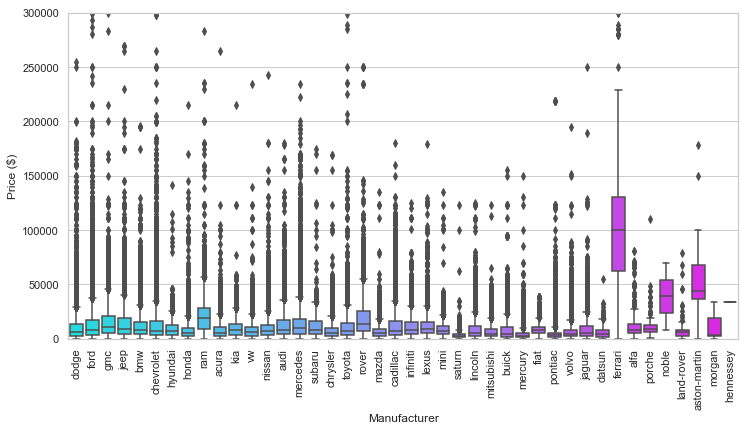

In [76]:
sns.boxplot(
    x='manufacturer',
    y='price',
    data=craig,
    palette='cool'
)
plt.xlabel('Manufacturer')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)
plt.ylim(0, 300000)
plt.show()

In [47]:
#singling out the number of rows with the commonly seen $1 price scam
craig_singledollar = craig.loc[craig.price == 1]
len(craig_singledollar)

17801

It looks like most of the manufacturers have realistic outliers up to 200,000 dollards except for Ferrari (will retain all of their datapoints). Given that pricing a car for 1 dollar on Craigslist is a strategy that sellers use to get buyers to look at their cars and not the actual value, I think will exclude the 1$ values from the target set. Because this is such a well known strategy, there are almost 18,000 cars listed for 1 dollar. Before doing any more data analysis or feature engineering I will filter the dataset to focus on the future modelled correlations. I want to do a quick breakdown of the most popular manufacturers and a breakdown prices by state.

In [44]:
craig_realistic = craig.loc[(craig['price'] > 1) & (craig['price'] <= 200000)] 
craig_fancy = craig.loc[(craig['manufacturer'] == 'ferrari') | (craig['manufacturer'] == 'aston-martin')]
craig_clean = pd.concat([craig_realistic, craig_fancy])

print('The modeled dataset is {} rows, down from {}. There were {} cars less than $1 and {} cars more than $200,000'.format(
    len(craig_clean),
    len(craig),
    len(craig.loc[craig['price'] <= 1]),
    len(craig.loc[craig['price'] > 200000]))
)

The modeled dataset is 1703745 rows, down from 1722224. There were 17763 cars less than $1 and 1047 cars more than $200,000


In [46]:
craig_clean.describe()

,price,year,odometer,lat,long,county_fips,state_fips,weather
count,1.703745e+06,1.697470e+06,1.151628e+06,1.703745e+06,1.703745e+06,1.645049e+06,1.645049e+06,1.644477e+06
mean,1.107115e+04,2.004895e+03,1.137688e+05,3.880895e+01,-9.374973e+01,2.845541e+04,2.836902e+01,5.375866e+01
std,1.199335e+04,1.200449e+01,1.358895e+05,5.967879e+00,1.698180e+01,1.605356e+04,1.603153e+01,7.793130e+00
min,1.000000e+00,3.020000e+02,0.000000e+00,-8.481005e+01,-1.000000e+03,1.001000e+03,1.000000e+00,2.900000e+01
25%,3.491000e+03,2.002000e+03,5.827100e+04,3.494748e+01,-1.059661e+02,1.212700e+04,1.200000e+01,4.800000e+01
50%,7.200000e+03,2.007000e+03,1.070000e+05,3.944610e+01,-8.828540e+01,2.902700e+04,2.900000e+01,5.300000e+01
75%,1.500000e+04,2.012000e+03,1.520000e+05,4.257152e+01,-8.102471e+01,4.106700e+04,4.100000e+01,5.900000e+01
max,3.450000e+06,2.019000e+03,1.000000e+07,9.000000e+01,1.397061e+02,5.604500e+04,5.600000e+01,7.900000e+01


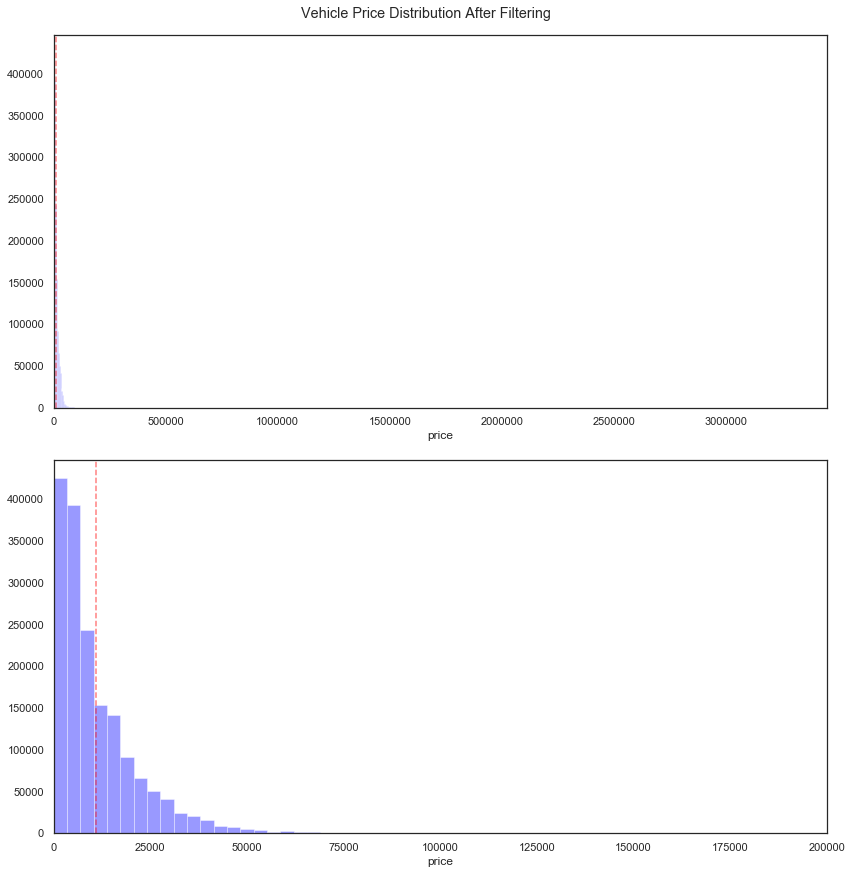

In [65]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.distplot(craig_clean.price, bins=1000, color='blue', kde=False)
plt.axvline(craig_clean.price.mean(), color='red', alpha=0.5, linestyle='--')
plt.xlim(0,3.45e6)

plt.subplot(2,1,2)
sns.distplot(craig_clean.price, bins=1000, color='blue', kde=False)
plt.axvline(craig_clean.price.mean(), color='red', alpha=0.5, linestyle='--')
plt.xlim(0,200000)

plt.suptitle('Vehicle Price Distribution After Filtering', y=1.01)
plt.tight_layout()
plt.show()

The distribution of prices is still heavily skewed to the right because of the Ferrari that is listed for 3.45 million dollars. However, the mean has come down an order of magnitude to a more reasonable 11,071.15 dollars. In total 18,479 vehicles were removed due to percieved pricing issues.

I think in future iterations it would be good to break the master dataframe into different manufacturer distributions and be more deliberate with the cutoff for the upper bound of prices. There could have been other manufacturers with legitimate cars priced over 200,000 dollars.

Use odometer, year, condition to filter out dummy prices in less than $100 range.

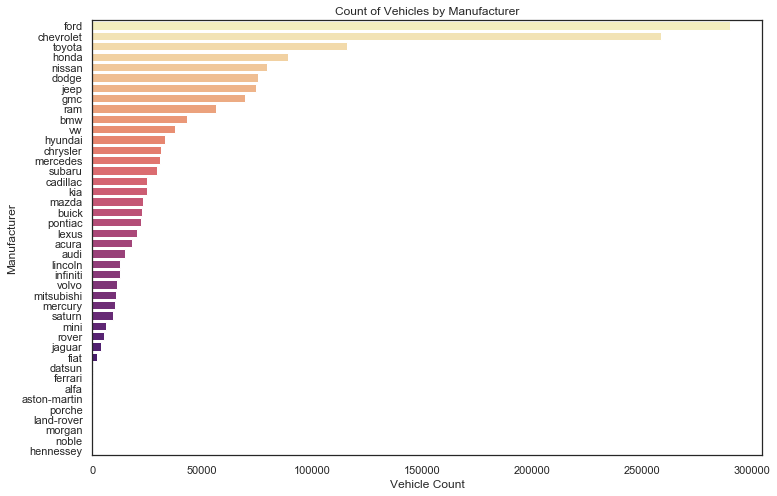

The top 5 car manufacturers sold on craigslist are 
ford         289978
chevrolet    258549
toyota       115772
honda         88867
nissan        79323
Name: manufacturer, dtype: int64,
and they make up 832489 rows of the total 1703745


In [66]:
#barchart showing the most listed manufacturers in the dataset
plt.figure(figsize=(12,8))
sns.barplot(
    craig_clean['manufacturer'].value_counts(),
    craig_clean['manufacturer'].value_counts().index,
    orient='h',
    palette='magma_r'
)
plt.xlabel('Vehicle Count')
plt.ylabel('Manufacturer')
plt.title('Count of Vehicles by Manufacturer')
plt.show()
print('The top 5 car manufacturers sold on craigslist are \n{},\nand they make up {} rows of the total {}'.format(
    craig_clean['manufacturer'].value_counts().head(5),
    craig_clean['manufacturer'].value_counts().head(5).sum(),
    len(craig_clean))
)

Ford, Chevrolet, Toyota, Honda, and Nissan make up almost 50% of the dataset. Ford and Chevrolet are the most popular vehicles posted on Craigslist by over double the volume of Toyota. Volume is a good measure to understand what type of car you're most likely to find on the site, but it doesn't tell us much about which vehicles are the most or least expensive.

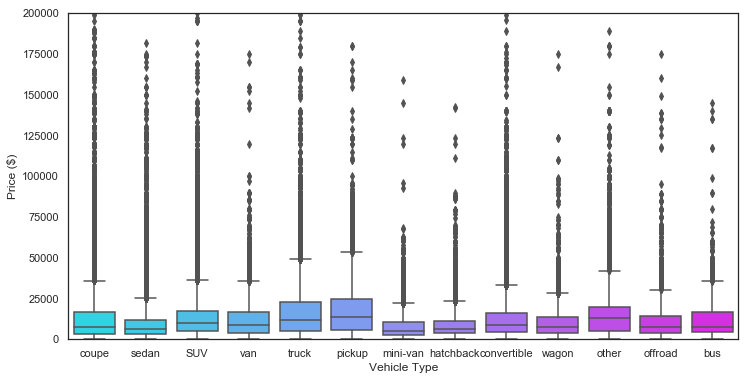

In [67]:
sns.boxplot(
    craig_clean.type,
    craig_clean.price,
    palette='cool'
)
plt.xlabel('Vehicle Type')
plt.ylabel('Price ($)')
plt.ylim(0,200000)
plt.show()

It looks like pickup's and trucks are the most expensive vehicles in the dataset. All of the vehicle type prices are right skewed with most of the prices falling at 20,000 dollars or below. The breakdown of prices for each type of vehicle could be very different based on what state/city the vehicles are from, which will be something important to look for.

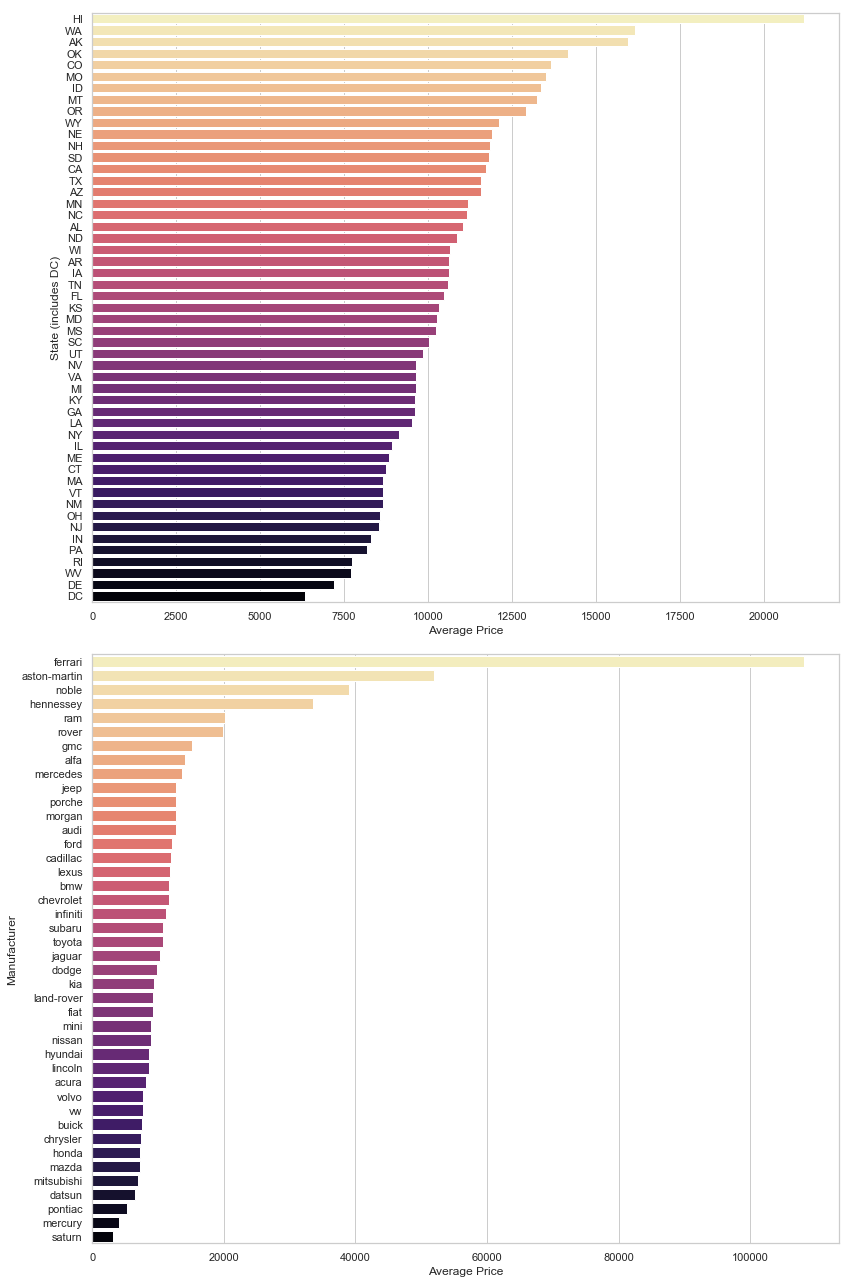

In [72]:
#averaging the vehicle price and manufacturer/state and sorting them for a barchart
state_df = craig_clean.groupby('state_code')['price'].aggregate(np.mean)
state_df.sort_values(ascending=False, inplace=True)
manufacturer_df = craig_clean.groupby('manufacturer')['price'].aggregate(np.mean)
manufacturer_df.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(12,18))
sns.set_style('whitegrid')
plt.subplot(2,1,1)
sns.barplot(
    state_df,
    state_df.index,
    orient='h',
    palette='magma_r'
)
plt.xlabel('Average Price')
plt.ylabel('State (includes DC)')

plt.subplot(2,1,2)
sns.barplot(
    manufacturer_df,
    manufacturer_df.index,
    orient='h',
    palette='magma_r'
)
plt.xlabel('Average Price')
plt.ylabel('Manufacturer')

plt.tight_layout()
plt.show()

The top 10 states based on average vehicle price have rugged terrains, are heavy agricultural states, or an island (cough cough Hawaii). That matches with trucks being the most expensive vehicles on average in the dataset. The top vehicles and states average prices will make good categorical variables of OLS. 

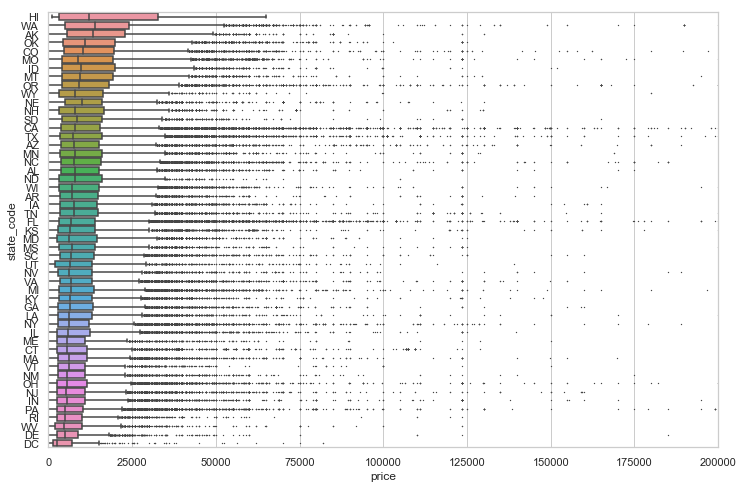

The number of vehicles in Hawaii:
False    1703723
True          22
Name: state_code, dtype: int64


In [81]:
plt.figure(figsize=(12,8))
sns.boxplot(
    craig_clean.price,
    craig_clean.state_code,
    orient='h',
    fliersize=0.5,
    order=state_df.index
)
plt.xlim(0,200000)
plt.show()
print('The number of vehicles in Hawaii:\n{}'.format((craig_clean['state_code'] == 'HI').value_counts()))

Although Hawaii has the highest average vehicle price, it only has 22 vehicles in the dataset. Hawaii might come down the list if there were more vehicles for sale considering the distribution of datapoints is not dissimilar from the other states. Seeing that the highest average prices come from Washington, Alaska, Oklahoma, and Colorado, weather and the drive of the vehicle will probably be important when considering the price. Before going there I want to better understand how mileage impacts the price.

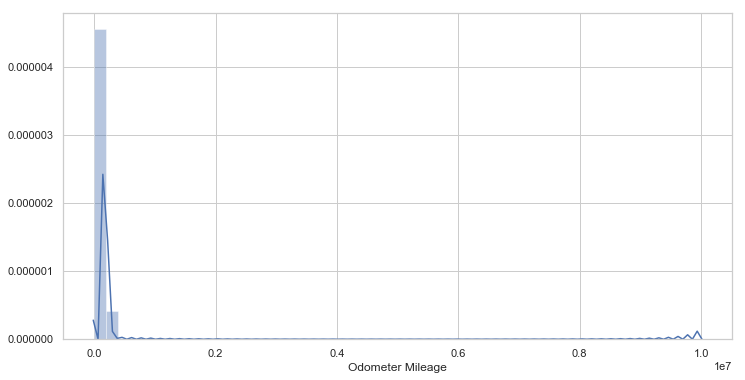

,price,year,odometer,lat,long,county_fips,state_fips,weather
count,2023.000000,2017.000000,2.023000e+03,2023.000000,2023.000000,1984.000000,1984.000000,1982.000000
mean,6622.201186,2000.690630,2.186826e+06,38.610849,-93.426390,27959.520161,27.874496,53.823915
std,9412.193518,9.476238,1.817957e+06,5.674345,16.352848,16066.212709,16.045695,7.974959
min,4.000000,1937.000000,1.000131e+06,-2.431258,-150.071182,1003.000000,1.000000,29.000000
25%,1850.000000,1998.000000,1.322898e+06,34.782900,-105.038797,12103.000000,12.000000,48.000000
50%,3500.000000,2003.000000,1.707011e+06,39.409200,-88.223700,27137.000000,27.000000,53.000000
75%,7300.000000,2006.000000,2.088832e+06,42.441300,-81.058795,41051.500000,41.000000,59.000000
max,141594.000000,2019.000000,1.000000e+07,64.673500,-69.247900,56025.000000,56.000000,71.000000


In [103]:
sns.distplot(craig_clean.odometer.dropna())
plt.xlabel('Odometer Mileage')
plt.show()

craig_clean.loc[craig_clean.odometer > 1000000].describe()

There is an uptick in vehicles with high mileage (> 1,000,000 miles) in the distribution. In total there are ~2000 rows with over 1 million miles. This could be for a couple reasons:

(1) there are actually that many vehicles that have broken the million mile mark 
(2) the seller mistyped the mile decimal as another full mile which would increase the mileage by an order of magnitude.
(3) the "vehicle" is a parts car w/no engine that the seller just number smashed a mileage

There are many reasons why the odometer reading's are well over what I think is a realistic value. For now I want to look at the correlations with price to see what affect mileage has on a cars percieved value.

Since it's almost impossible to know if the high odometer readings are real, I will work on an imputation workflow for a future iteration of the model. For now, I will cap the dataset at 1 million miles and move forward with EDA and Feature Engineering.

In [104]:
craig_clean = craig_clean.loc[craig_clean['odometer'] < 1000000]

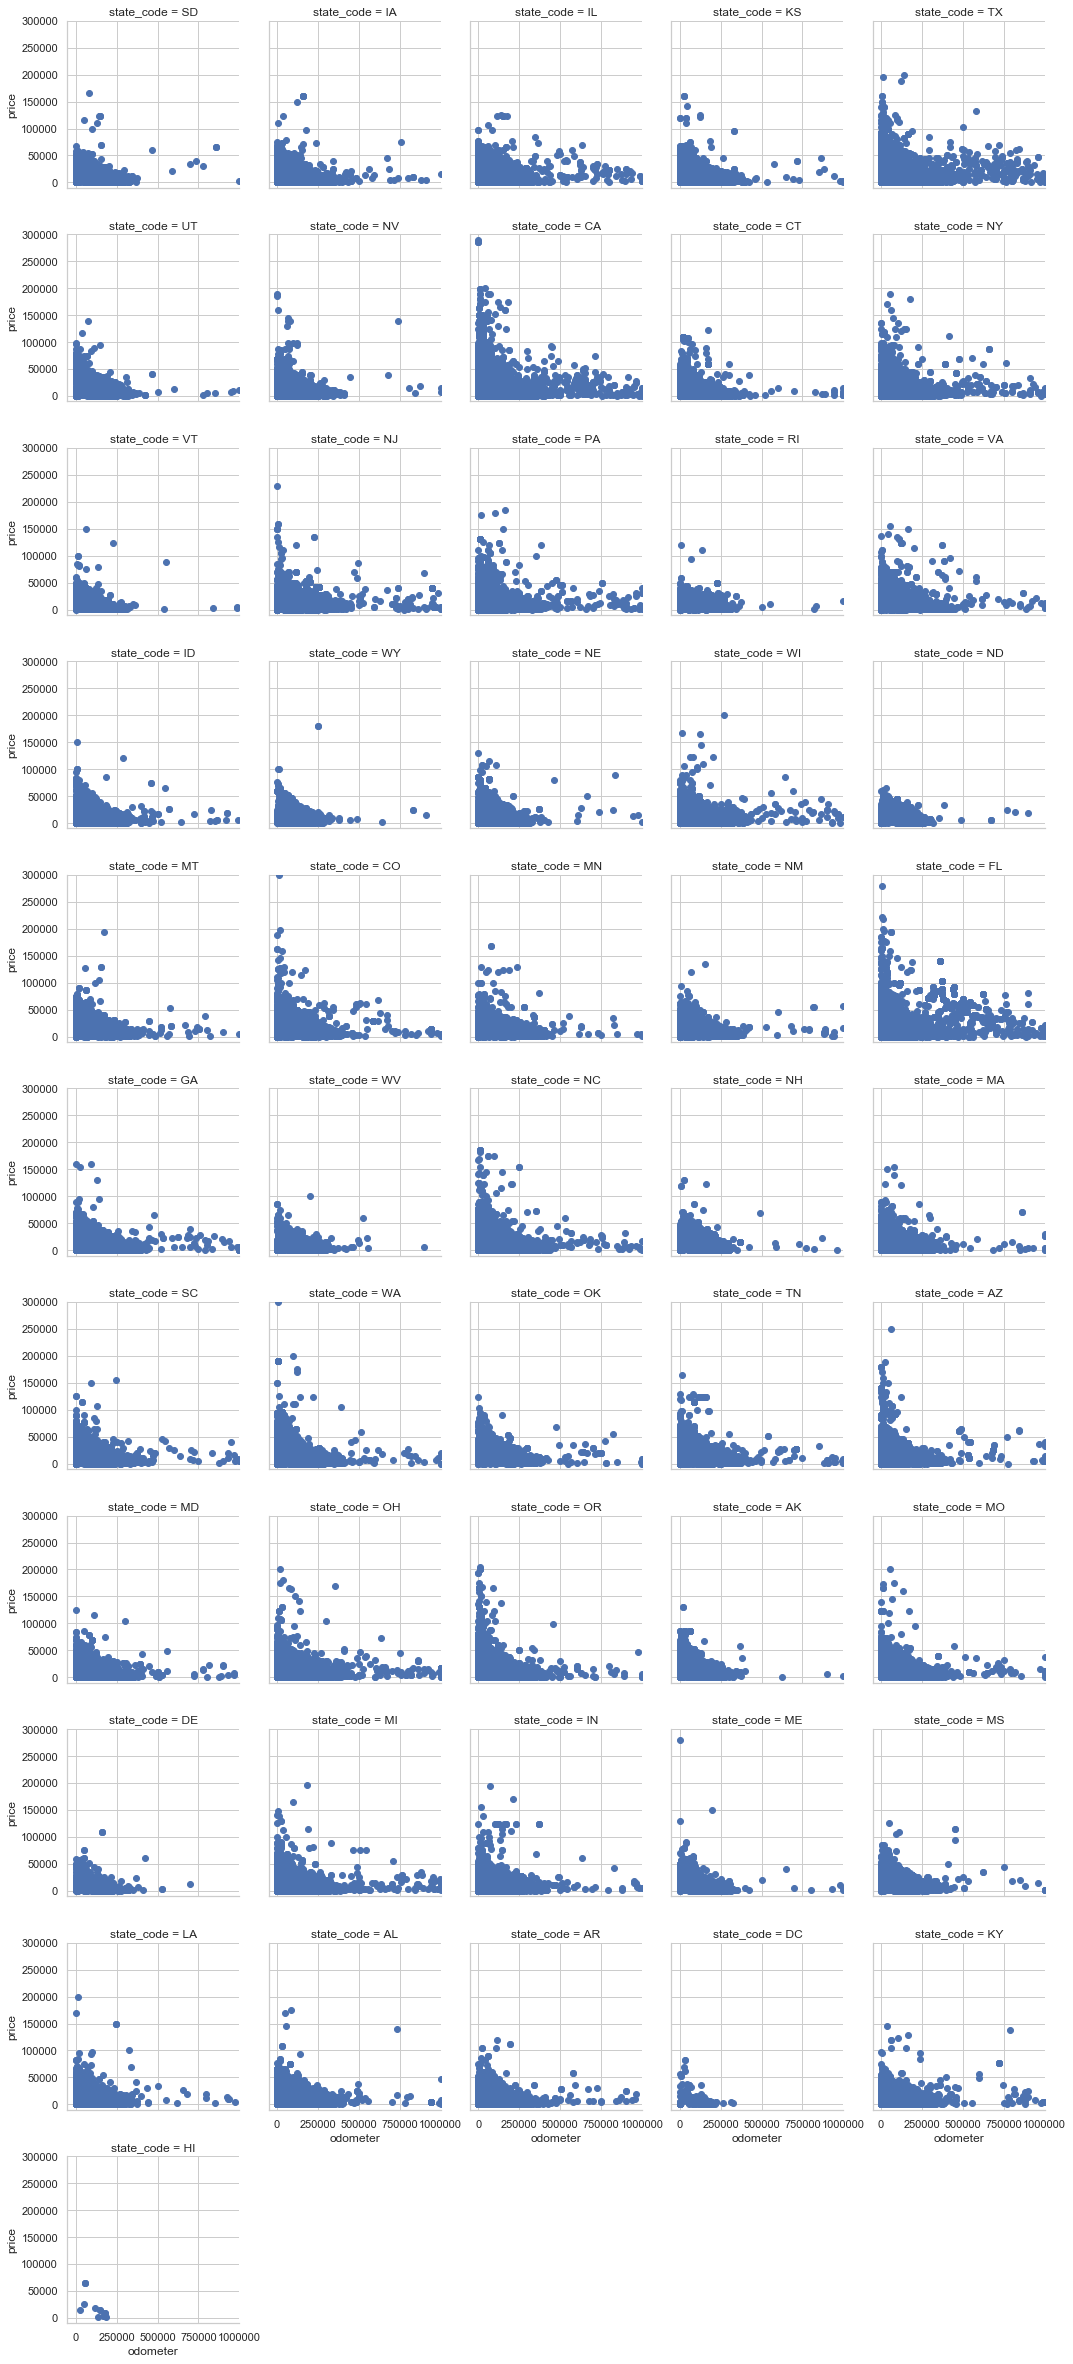

In [108]:
g = sns.FacetGrid(data=craig_clean, col='state_code', col_wrap=5)
g.map(plt.scatter, 'odometer', 'price')
plt.ylim(-10000, 300000)
plt.xlim(-50000, 1000000)
plt.show()

In all the states there is an increase in car value as mileage decreases. There is quite a lot of scatter as mileage drops below ~150,000, but the correlation still looks good. Likely there are a few cases where certain car model values are less influenced by mileage than others (i.e. classic cars with low mileage that are unrestored will be less expensive than restored cars with higher mileage). This will be useful for the knn regression model.

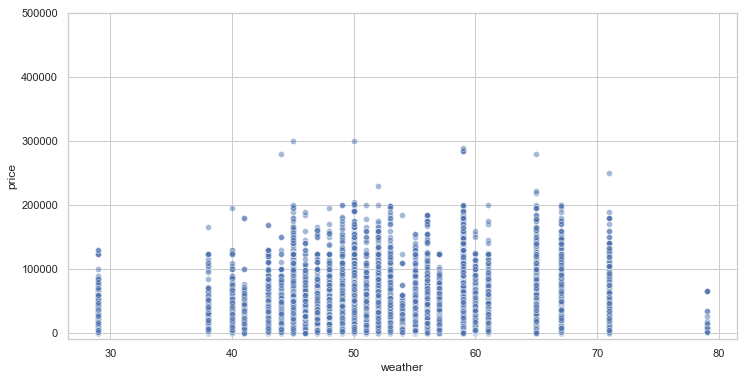

In [94]:
sns.scatterplot(
    x=craig_clean.weather,
    y=craig_clean.price,
    alpha=0.5,
    #hue=craig_clean.type
)
plt.ylim(-10000,500000)
plt.show()

There isn't a clear correlation between weather and price on the gross scale. Because the temperature for each listing is an average for October-November in the state, this is essentially a categorical variable that mimics the state_code. I could try and look at the temp vs. price broken out by car_type or manufacturer to see if there would be a good categorical feature to use in a future iteration.

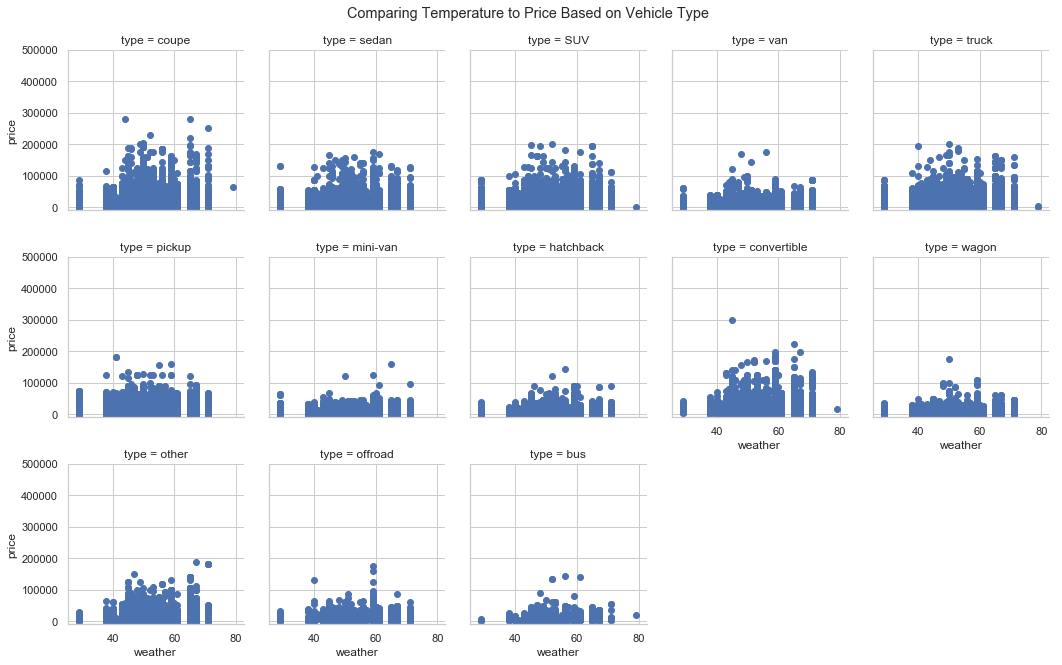

In [113]:
g = sns.FacetGrid(data=craig_clean, col='type', col_wrap=5)
g.map(plt.scatter, 'weather', 'price')
plt.ylim(-10000, 500000)
plt.suptitle('Comparing Temperature to Price Based on Vehicle Type', y=1.025)
plt.show()

Convertibles have a slight, positive correlation with the average state weather that I assume would be stronger if the weather variable was more granular.

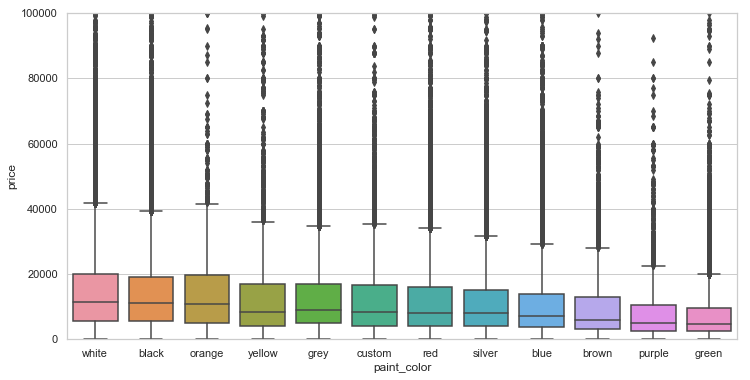

paint_color
white     14555.344223
black     14139.602555
orange    13983.033638
yellow    13082.153425
grey      12328.582644
custom    11944.405172
red       11692.410819
silver    11157.910608
blue      10356.351855
brown      9702.600935
purple     8612.006285
green      7659.424415
Name: price, dtype: float64


In [155]:
paint = craig_clean.groupby('paint_color')['price'].aggregate(np.mean).sort_values(ascending=False)

sns.boxplot(
    craig_clean.paint_color,
    craig_clean.price,
    order=paint.index
)
plt.ylim(0, 100000)
plt.show()

print(paint)

White and black cars are the most expensive on average in the dataset. There isn't a large difference between them and the next lowest (orange). The real spread comes from the low end, green cars are on average ~half the price of the white, black, orange, and yellow cars. Maybe a feature denoting cars that aren't green or purple would be helpful. this could also change based on the type of car. 

<Figure size 864x1296 with 0 Axes>

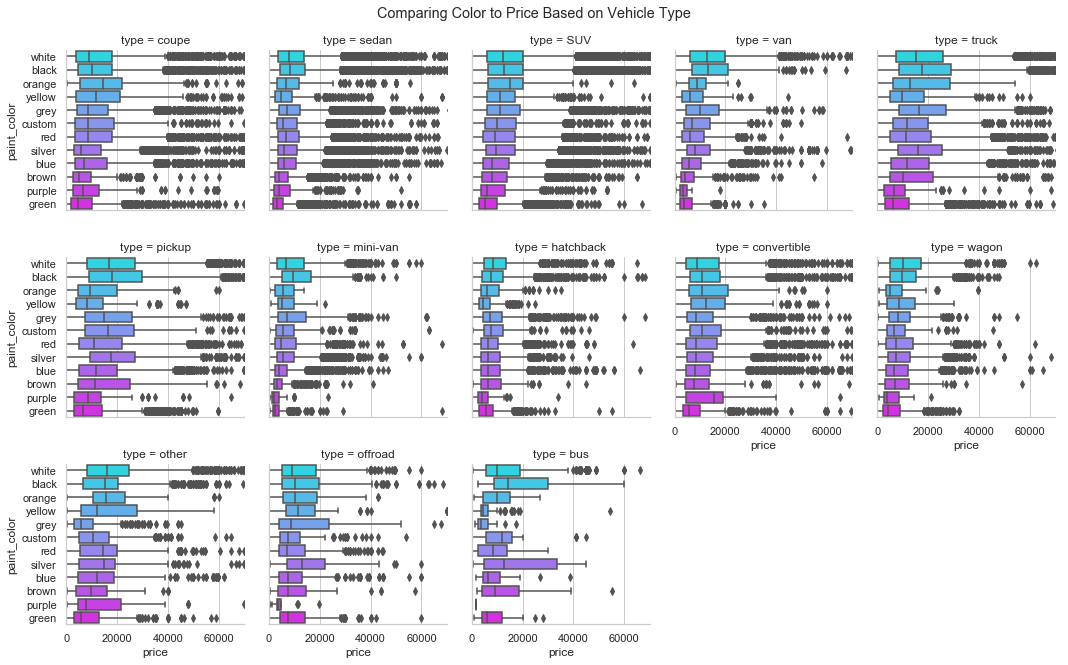

In [177]:
plt.figure(figsize=(12,18))
g = sns.FacetGrid(data=craig_clean, col='type', col_wrap=5)
g.map(sns.boxplot, 'price', 'paint_color', palette='cool', order=paint.index)
plt.xlim(0, 70000)
plt.suptitle('Comparing Color to Price Based on Vehicle Type', y=1.025)
plt.show()

The distributions of price by paint color mostly stay the same when broken out by vehicle type. Buses, coupes, trucks, and convertibles all have different max means than the overall dataset. Offroad vehicles and the other type might have different paint colors with a higher price.

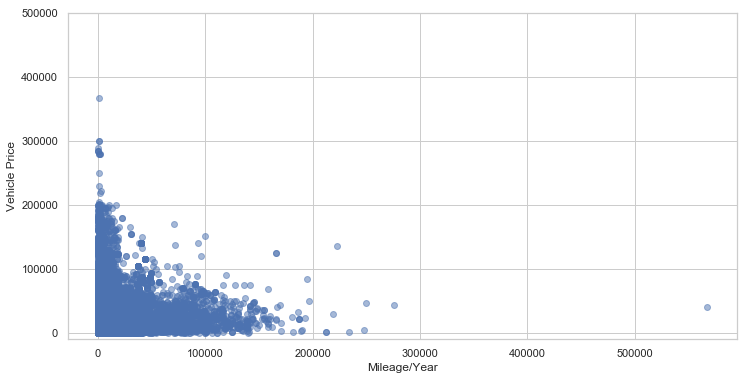

In [209]:
#creating an age column based on the year and calculating the average mileage/year
craig_clean['vehicle_age'] = 2020 - craig_clean.year
craig_clean['mileage_per_year'] = craig_clean.odometer / craig_clean.vehicle_age

plt.scatter(
    craig_clean.mileage_per_year,
    craig_clean.price,
    alpha=0.5
)
plt.xlabel('Mileage/Year')
plt.ylabel('Vehicle Price')
plt.ylim(-10000, 500000)
plt.show()

The price of the vehicles increase as the mileage/year decreases. This is another variable that could be influenced by the type of vehicle being driven as I assume some cars will be driven less miles/year than others.

<Figure size 864x1296 with 0 Axes>

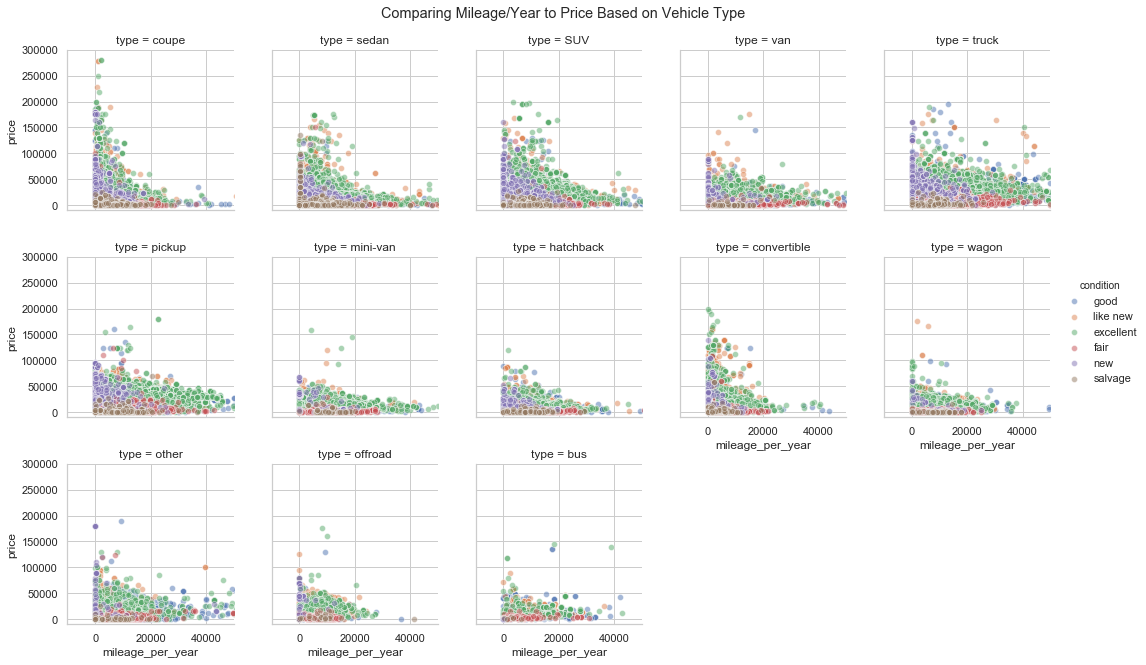

In [216]:
plt.figure(figsize=(12,18))
g = sns.FacetGrid(data=craig_clean, col='type', col_wrap=5, hue='condition', legend_out=True)
g.map(sns.scatterplot, 'mileage_per_year', 'price', alpha=0.5).add_legend()
plt.ylim(-10000, 300000)
plt.xlim(-10000, 50000)
plt.suptitle('Comparing Mileage/Year to Price Based on Vehicle Type', y=1.025)
plt.show()

There are definitely some outliers on the high end of mileage/year, which could help to identify vehicles with unrealistic odometer values. The interesting part of the correlations are that trucks, pickups, and type-other vehicles are not decreasing in price with increasing mileage/year as fast as the other vehicle types. Predictably the convertibles seem to decrease in price the fastest. Offroad vehicles also seem to decrease quickly, but I assume it's because these vehicles don't see as many miles as normal cars.

<Figure size 864x1296 with 0 Axes>

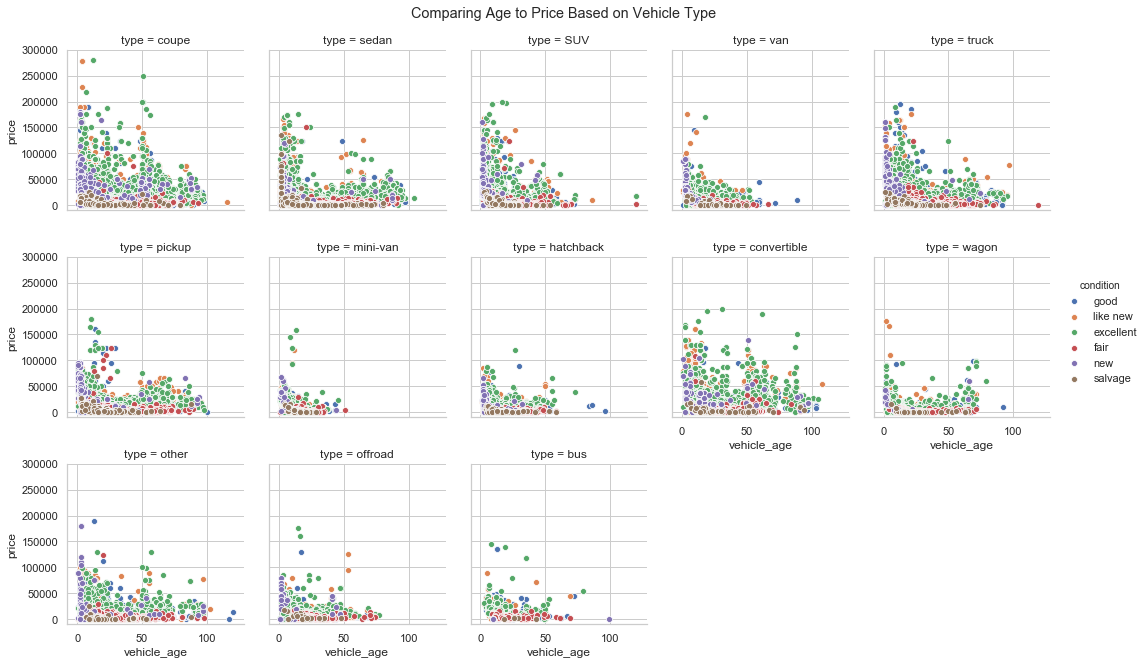

In [211]:
plt.figure(figsize=(12,18))
g = sns.FacetGrid(data=craig_clean, col='type', col_wrap=5, hue='condition', legend_out=True)
g.map(sns.scatterplot, 'vehicle_age', 'price').add_legend()
plt.ylim(-10000, 300000)
plt.suptitle('Comparing Age to Price Based on Vehicle Type', y=1.025)
#plt.legend()
plt.show()

Most of the vehicle types in the dataset decrease in price with age, except for the wagons. There is a slight decrease, but overall they are relatively flat with age. There could be a useful feature with limiting the price prediction on age if the vehicle isn't a wagon. If the vehicle is a salvage, it doesn't matter the age or the type of car, the price is still very low. I will need to do further digging into the salvage cars to determine what is controlling their price.

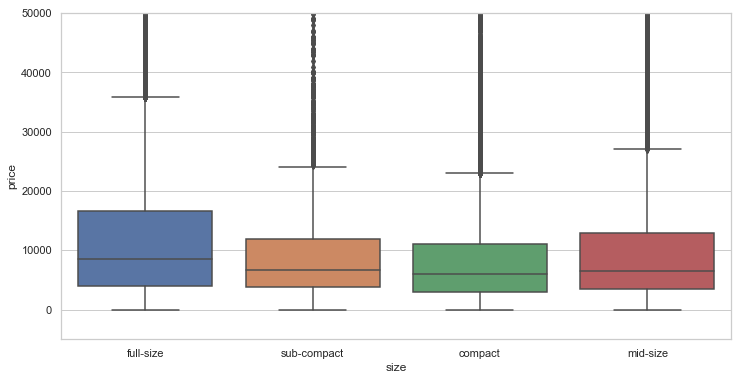

In [198]:
sns.boxplot(
    craig_clean['size'],
    craig_clean['price']
)
plt.ylim(-5000, 50000)
plt.show()

The breakout of prices based on vehicle is very predictable. Full-size are the most expensive followed by mid-size and sub-compact. There could be some issues with what is being defined as sub-compact vs. compact. It's strange that compact cars would be cheaper than sub-compact.

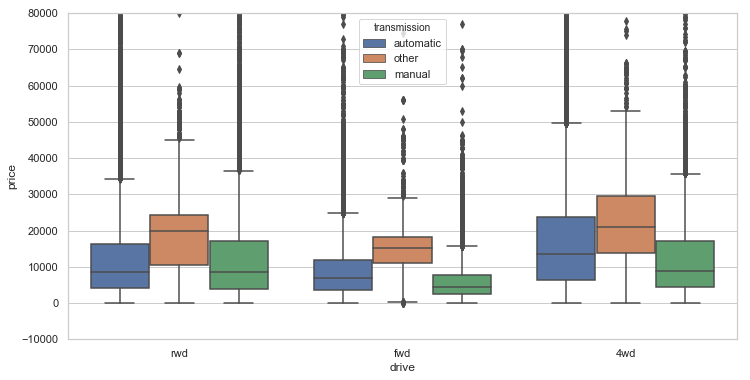

Transmission type-other accounts for 20654 observations


In [206]:
sns.boxplot(
    craig_clean['drive'],
    craig_clean['price'],
    hue=craig_clean['transmission']
)
plt.ylim(-10000, 80000)
plt.show()
print('Transmission type-other accounts for {} observations'.format(len(craig_clean.loc[craig_clean.transmission == 'other'])))

The other type accounts for a small portion of the dataset, but it is unclear as to what this means. Some further digging to determine what the other possible transmissions are needs to be done.

There does seem to be some separation between the drive of the car and the transmission when it comes to price. Only rear wheel drive cars are equal when it comes to price vs. transmission type (manual might have an edge here). Otherwise, manual transmissions are on average less expensive than automatics.

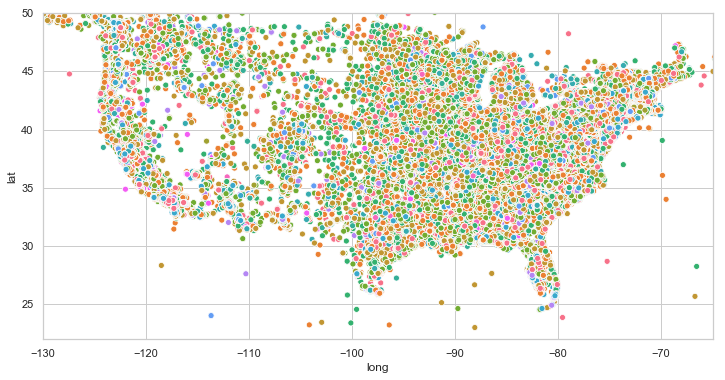

In [226]:
sns.scatterplot(
    craig_clean.long,
    craig_clean.lat,
    hue=craig_clean['type'],
    sizes=(100, 70000),
    legend=False
)
plt.xlim(-130, -65)
plt.ylim(22, 55)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

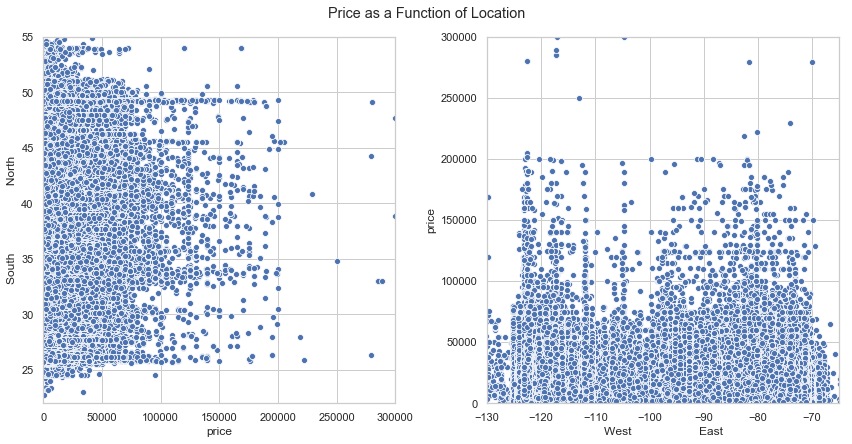

In [233]:
plt.subplot(1,2,1)
sns.scatterplot(
    craig_clean.price,
    craig_clean.lat
)
plt.ylabel('South                    North')
plt.ylim(22, 55)
plt.xlim(0, 300000)

plt.subplot(1,2,2)
sns.scatterplot(
    craig_clean.long,
    craig_clean.price
)
plt.xlabel('West                    East')
plt.xlim(-130, -65)
plt.ylim(0, 300000)

plt.suptitle('Price as a Function of Location', y=1.025)
plt.tight_layout()
plt.show()

Price does not seem to be affected on the gross scale by any sort of regional boundary. The vehicles over 200,000 dollars are Ferraris, which do not show up in the middle of the country. The longitude might be useful in helping to predict the upper end cars in the knn model that cannot take categorical features. I have outlined above how some states have higher prices on average than other, but there doesn't seem to be any sort of regional trends present. Likely the type of vehicle in each specific area will have different price tendencies. For example, trucks are probably worth more in states with harsh weather or they are needed for economic reasons, where they are likely less expensive in cities because the market would be softer.

### Feature Set

Since the point of this challenge is to compare/contrast knn regression to OLS, and knn regression cannot handle binary variables, I am going to move forward with the features that I have built to compare the two models. I am going to throw in the state_fips code which is technically a categorical variable with a numeric encoding to see how it will behave. If the knn model looks off, I will exclude it.

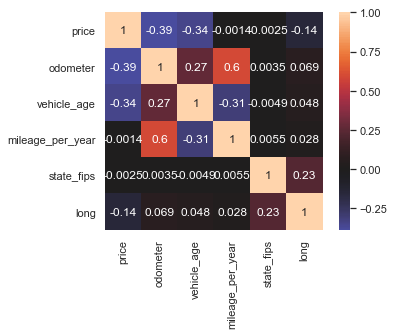

In [268]:
model_df = craig_clean.loc[:,['price',
                              'odometer',
                              'vehicle_age',
                              'mileage_per_year',
                              'state_fips',
                              'long'
                             ]]
model_df.dropna(inplace=True)
sns.set(style='white')
sns.heatmap(model_df.corr(), center=0, annot=True, square=True)
plt.show()

It makes sense that the mileage per year weakly correlates to the odometer and vehicle age since they went into the creation of the feature. For these models I am more worried about the predictive capability between knn and OLS, so I am going to leave them all in the model. 

### Train - Test Split for Modeling 

In [254]:
X = model_df.drop(['price'], axis=1)
Y = model_df['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 38)

print('The number of observations in training: {}'.format(len(X_train)))
print('The number of observations in test: {}'.format(len(X_test)))

s = StandardScaler()
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

The number of observations in training: 879558
The number of observations in test: 219890


### OLS Model

In [262]:
lreg = LinearRegression()
lreg.fit(X_train, Y_train)
Y_train_pred = lreg.predict(X_train)
Y_test_pred = lreg.predict(X_test)
print('The R-squared of the Training Set is: {:0.2f}'.format(lreg.score(X_train, Y_train)))
print('The RMSE of the Training Set is: {:.0f}'.format(rmse(Y_train, Y_train_pred)))

print('The R-squared of the Test Set is: {:0.2f}'.format(lreg.score(X_test, Y_test)))
print('The RMSE of the Test Set is: {:.0f}'.format(rmse(Y_test, Y_test_pred)))

The R-squared of the Training Set is: 0.27
The RMSE of the Training Set is: 9708
The R-squared of the Test Set is: 0.19
The RMSE of the Test Set is: 12118


There is quite a large gap between the training R-squared and the test R-squared and both are quite low. Also, considering the mean price of the vehicles is around 11,000 dollars the RMSE for both the train and test sets did a very poor job. The RMSE of the test set is more than the average price of the vehicles which shows that the model is performing very poorly. I think the model is performing this poorly because there are not enough features to explain the variance in the target variable. Given that this dataset as a standalone is more prone to categorical features that cannot be accounted for in a knn model and is likely why the performance is so weak. Even having yet to perform the knn regression model it is easy to see that it will likely not good predictive power.

In [265]:
knn_w = KNeighborsRegressor(n_neighbors=10, weights='distance')

knn_w.fit(X_train, Y_train)
Y_train_pred = knn_w.predict(X_train)
Y_test_pred = knn_w.predict(X_test
                           )
score_w_train = cross_val_score(knn_w, X_train, Y_train, cv=5)
score_w_test = cross_val_score(knn_w, X_test, Y_test, cv=5)

print('knn regression with 10 neighbors')
print('Training R-squared : {:.2f}'.format(score_w_train.mean()))
print('Training RMSE : {:.0f}'.format(rmse(Y_train, Y_train_pred)))
print('Test R-squared: {:.2f}'.format(score_w_test.mean()))
print('Test RMSE: {:.0f}'.format(rmse(Y_test, Y_test_pred)))

knn regression with 10 neighbors
Training R-squared : 0.65
Training RMSE : 782
Test R-squared: 0.32
Test RMSE: 9795


The generalization gap between the training set and test set is quite high and indicative of overfitting the training set. This could be managed some by adjusting the number of neighbors to decrease the overfitting. The results from the test set of knn regression was much better than that of the OLS model with a better R-squared and lower RMSE. Even though it is better the RMSE is still quite large when compared to the mean. Given that the inclusion of more features is needed for both models and this dataset alone has more potential for categorical variables, I do not think that knn regression is the right choice.